In [62]:
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import prettytable as pt
%run helpers_preproc.ipynb
%matplotlib widget

# Hyper Parameters

In [63]:
origDataDir = 'SHREC11/'
newDataDir = 'SHREC11_plus/'
K = 5
radiuss = [0.0002,0.0004,0.0008]
train_size = 450 * len(radiuss)
test_size = (600-450) * len(radiuss)

# 1. expand dataset and scramble

In [5]:
expand(origDataDir, newDataDir, radiuss)
scramble(newDataDir, 10000,600 * len(radiuss))

# 2. read in the dataset

## 2.1 read in v (252 x 3),f (...x...) and cluster

In [6]:
ver_list = []
adj_list = []
Nadj_list = []
gMat_list = []
gLbl_list = []

for i in range(600 * len(radiuss)):
    v, f = get_nodes(newDataDir + 'T' + str(i) + '.obj')
    group_mat, group_labels = K_mean_cluster(v, K)
    
    adj = get_adj_from_f(f)            
    normed_adj = adj / np.reshape(np.sum(adj,axis = 0),[252,1])
    ver_list.append(v)
    adj_list.append(adj)
    Nadj_list.append(normed_adj)
    gMat_list.append(group_mat)
    gLbl_list.append(group_labels)
    
    
vers = np.array(ver_list)
adjs = np.array(adj_list)
Nadjs = np.array(Nadj_list)
gMats = np.array(gMat_list)
gLbls = np.array(gLbl_list)

/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_17703/2399023897.py:12: RuntimeWarning: invalid value encountered in divide
  normed_adj = adj / np.reshape(np.sum(adj,axis = 0),[252,1])


## 2.2 Read in the labels

In [7]:
label_np = np.array(readLbl(600 * len(radiuss),newDataDir+'labels.txt'))
label_np_train = label_np[:train_size]
label_np_test = label_np[train_size:]

## 2.3 Split into training set and testing set

In [8]:
vers_train = torch.tensor(vers[:train_size]).float()
adjs_train = torch.tensor(adjs[:train_size]).float()
nadjs_train = torch.nan_to_num(torch.tensor(Nadjs[:train_size]).float(),0,0,0)
gMats_train = torch.tensor(gMats[:train_size]).float()
label_train = torch.tensor(label_np_train).float()

vers_test = torch.tensor(vers[train_size:]).float()
adjs_test = torch.tensor(adjs[train_size:]).float()
nadjs_test = torch.nan_to_num(torch.tensor(Nadjs[train_size:]).float(),0,0,0)
gMats_test = torch.tensor(gMats[train_size:]).float()
label_test = torch.tensor(label_np_test).float()

label_mat_train = torch.tensor(np.where(igl.all_pairs_distances(label_np_train,label_np_train,False) > 0.5,0,1)).float()
label_mat_test = torch.tensor(np.where(igl.all_pairs_distances(label_np_test,label_np_test,False) > 0.5,0,1)).float()

In [9]:
#detect_nan(label_mat_train)

In [10]:
#label_mat_train

In [11]:
#print message about training and testing dataset
# print(vers_train.shape)
# print(adjs_train.shape)
# print(nadjs_train.shape)
# print(gMats_train.shape)

# 3. Training

## 3.1 Hyperparameters for training

In [39]:
contraGWs = [5,5,5,5]
contraMWs = [5,5,5,5]
atkGWs = [5,5,5,5]
atkMWs = [5,5,5,K * 3 + 1]

## 3.2 Initialize neural networks

In [73]:
%run NNs.ipynb
%run helpers_preproc.ipynb
contraG = GCN(3,contraGWs)
contraM = MLP(252* contraGWs[len(contraGWs)-1],contraMWs)
atkG = GCN(3,atkGWs)
atkM = MLP_atk(252* atkGWs[len(contraGWs)-1], 0.5, K, atkMWs)

## 3.4 Extract node-level features from clean data

In [74]:
feas_clean = extract_node_feature(vers_train,adjs_train)

In [75]:
%run L.ipynb

## 3.5 Feed clean data into contraNN🤠

## 3.6 Train atkNN😈 with contraNN🤠

In [76]:
atkLR = 0.0001
contraLR = 0.0001
torch.set_printoptions(precision=10)

In [ ]:
#get clean features
feas_clean = extract_node_feature(vers_train,adjs_train) #grad on nothing
opt = optim.Adam(atkG.weights + atkM.weights + contraG.weights + contraM.weights, lr = 0.001)

for contraI in range(1000):
    trainLog = pt.PrettyTable()
    trainLog.field_names = [" ","Loss", "Same Mean", "Diff Mean", "Same STD"]
    
    
    opt.zero_grad()

    #get poisoned vertex locations
    poisonsByGroups = atkM.forward(atkG.forward(nadjs_train,feas_clean))
    transformation = translate_by_group(gMats_train,
                                        poisonsByGroups)
    poisonedVers = vers_train + transformation
        
        
    #extract poisoned features
    feas_poisoned = extract_node_feature(poisonedVers,adjs_train) #grad on 😈

    
    #get contraNN's performance on poisoned feature with grads on 😈    
    contraM.eval()
    contraG.eval()
    aPerfPoisoned, APP = loss(contraM.forward(contraG.forward(nadjs_train,feas_poisoned)),
                         label_mat_train) #grad on 😈
    
    #get contraNN's performance on clean feature and poisoned feature with grads on 🤠
    contraM.train()
    contraG.train()
    feas_poisoned_nograd = feas_poisoned.detach() #grad on nothing
    
    objFeasFromClean = contraM.forward(contraG.forward(nadjs_train,feas_clean))
    objFeasFromPoisoned = contraM.forward(contraG.forward(nadjs_train,feas_poisoned_nograd))
    
    diffInFeas = torch.sum((objFeasFromClean - objFeasFromPoisoned)**2)
    
    cPerfClean, CPC = loss(objFeasFromClean,
                      label_mat_train) #grad on 🤠
    
    cPerfPoisoned, CPP = loss(objFeasFromPoisoned,
                         label_mat_train) #grad on 🤠
    
    
    trainLog.add_row(['On Clean Data']+CPC)
    trainLog.add_row(['On Poisoned Data']+CPP)

    
    overallLoss = -aPerfPoisoned + cPerfClean + cPerfPoisoned#  + diffInFeas
    overallLoss.backward()
    opt.step()
    
    print(trainLog)
    
    

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.00325 |  0.00781  |   0.0115  | 0.04341  |
| On Poisoned Data | -0.00333 |  0.00774  |   0.0115  | 0.04286  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.0049  |  0.01093  |  0.01644  | 0.06082  |
| On Poisoned Data | -0.00504 |   0.0108  |  0.01643  | 0.05975  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.06868 |  0.10627  |  0.18084  | 0.58933  |
| On Poisoned Data | -0.06926 |  0.10551  |   0.1806  | 0.58266  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.07413 |  0.11309  |  0.19349  | 0.62714  |
| On Poisoned Data | -0.07466 |  0.11232  |  0.19318  | 0.62029  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.25215 |  0.34347  |  0.61472  | 1.90956  |
| On Poisoned Data | -0.25393 |  0.34022  |  0.61296  | 1.88145  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.26247 |  0.35015  |  0.63211  | 1.94869  |
| On Poisoned Data | -0.26439 |  0.34629  |  0.62985  | 1.91631  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.43729 |  0.55415  |  1.02255  | 3.11132  |
| On Poisoned Data | -0.44242 |   0.5454  |  1.01822  |  3.0401  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.44445 |  0.55624  |  1.03192  | 3.12346  |
| On Poisoned Data | -0.44843 |  0.54799  |   1.027   | 3.05737  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.54181 |  0.68315  |  1.26362  | 3.86558  |
| On Poisoned Data | -0.54677 |  0.67182  |  1.25632  | 3.77339  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.54934 |  0.70034  |  1.28928  | 3.96022  |
| On Poisoned Data | -0.55458 |   0.6917  |   1.2851  | 3.88221  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.6135  |  0.79264  |  1.45139  | 4.52461  |
| On Poisoned Data | -0.61953 |  0.78184  |  1.44559  | 4.42237  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+----------+
|  On Clean Data   | -0.61158 |  0.78918  |  1.44578  |  4.5024  |
| On Poisoned Data |  -0.611  |   0.7817  |  1.43705  |  4.4351  |
+------------------+----------+-----------+-----------+----------+
+------------------+----------+-----------+-----------+----------+
|                  |   Loss   | Same Mean | Diff Mean | Same STD |
+------------------+----------+-----------+-----------+-------

## 3.7 Seeing how it does on Test Data

In [ ]:
feas_clean_test = extract_node_feature(vers_test,adjs_test)

atkTest = atkM.forward(atkG.forward(nadjs_test,feas_clean_test))

poisonedVersTest = vers_test + translate_by_group(gMats_test,atkTest)
        
feas_poisoned_test = extract_node_feature(poisonedVersTest,adjs_test)
        
contraOutPoisonedTest = contraM.forward(contraG.forward(nadjs_test,feas_poisoned_test))
contraLossPoisonedTest,_ = loss(contraOutPoisonedTest,label_mat_test)

contraOutCleanTest = contraM.forward(contraG.forward(nadjs_test,feas_clean_test))
contraLossCleanTest,_ = loss(contraOutCleanTest,label_mat_test)

print(contraLossPoisonedTest)
print(contraLossCleanTest)

In [71]:
# plt.clf()

torch.Size([202500])
torch.Size([202500])
0.000110162284 0.00011579676
torch.Size([202500])
torch.Size([202500])
1.2692829 2.0718827
torch.Size([202500])
torch.Size([202500])
1.2692829 2.0718827


/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_17703/3591612746.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_same = torch.tensor(label_mat - torch.diag(torch.ones(size)),dtype=bool).flatten()
/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_17703/3591612746.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_diff = torch.tensor(1 - label_mat,dtype=bool).flatten()
/var/folders/y9/sgsdqvs575j76jqnz728mwkh0000gn/T/ipykernel_17703/3036115838.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_same =

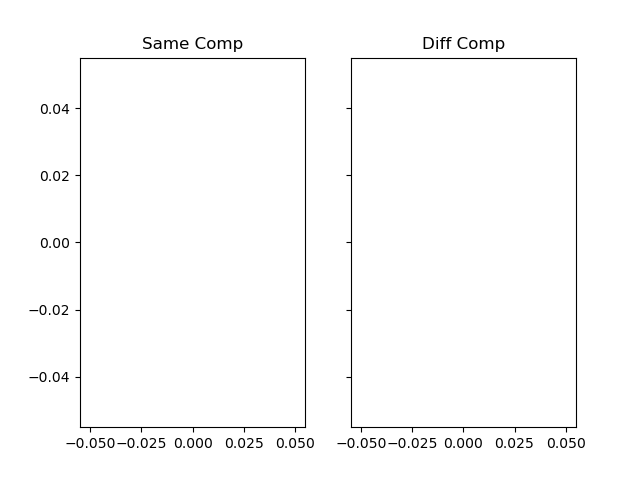

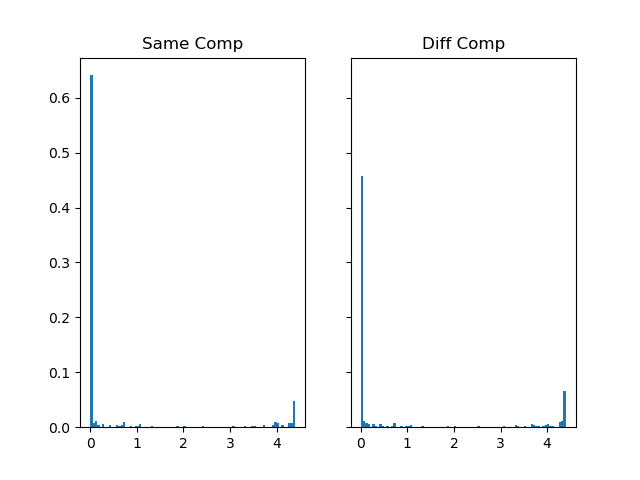

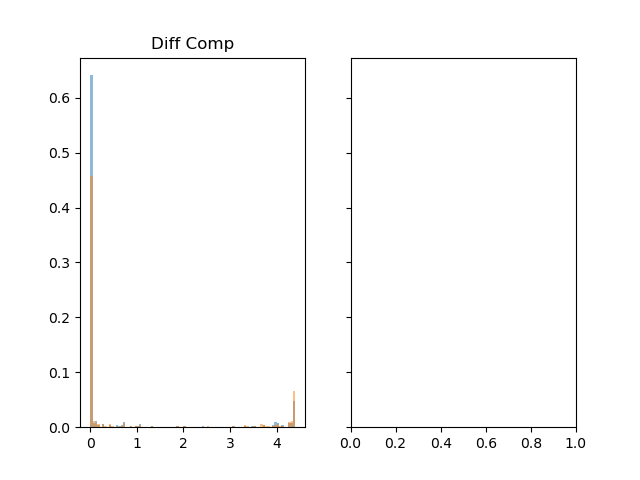

In [72]:
feas_clean_test = extract_node_feature(vers_test,adjs_test)

atkTest = atkM.forward(atkG.forward(nadjs_test,feas_clean_test))

poisonedVersTest = translate_by_group(gMats_test,atkTest)

feas_poisoned_test = extract_node_feature(poisonedVersTest,adjs_test)

contraOutPoisonedTest = contraM.forward(contraG.forward(nadjs_test,feas_poisoned_test))
contraLossPoisonedTest = loss(contraOutPoisonedTest,label_mat_test)

contraOutCleanTest = contraM.forward(contraG.forward(nadjs_test,feas_clean_test))
contraLossCleanTest = loss(contraOutCleanTest,label_mat_test)

#display histograms
display_hist(contraOutPoisonedTest, label_mat_test, test_size)
display_hist(contraOutCleanTest, label_mat_test, test_size)

display_hists(contraOutCleanTest, label_mat_test, test_size)

In [ ]:
plt.clf()

In [ ]:
from mpl_toolkits.mplot3d import axes3d


index_in_question = 1

#Plot first clustered mesh
dataPlot = vers[index_in_question]

fig = plt.figure()
ax = fig.add_subplot(121,projection='3d')

ax.scatter(dataPlot[:,0], dataPlot[:,1], dataPlot[:,2], label=gLbls[index_in_question,:], c = gLbls[index_in_question,:], cmap = 'viridis',s = 3)
ax.set_title('clean')

plt.axis('off')

#Plot second clustered point coud
#get poison
atkOut = atkM.forward(atkG.forward(nadjs_train,feas_clean))
poisonedVers = translate_by_group(vers_train,gMats_train,atkOut).detach().numpy()

print(poisonedVers.shape)
#poisioedVers = np.zeros([1350,252,3])
poisonedDataPlot = vers[index_in_question] + poisonedVers[index_in_question]

ax = fig.add_subplot(122,projection='3d')

ax.scatter(poisonedDataPlot[:,0], poisonedDataPlot[:,1], poisonedDataPlot[:,2], label=gLbls[index_in_question,:], c = gLbls[index_in_question,:], cmap = 'viridis', s = 3)
ax.set_title('poisoned')

plt.axis('off')

plt.show()

In [ ]:
# ax.axes.xaxis.set_ticklabels([])
# ax.axes.yaxis.set_ticklabels([])
# ax.axes.zaxis.set_ticklabels([])
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')